
# 7.10 Optimize simulated rhythmic responses

This example demonstrates how to optimize the power spectral density (PSD)
of a current dipole signal with significant alpha and beta spectral
components.


In [1]:
# Authors: Carolina Fernandez <cxf418@miami.edu>

from hnn_core.viz import plot_psd
from hnn_core.optimization import Optimizer
import matplotlib.pyplot as plt

--No graphics will be displayed.


Let us import hnn_core



In [2]:
from hnn_core import (MPIBackend, jones_2009_model, simulate_dipole)

# The number of cores may need modifying depending on your current machine.
n_procs = 10

First, we define a function that will tell the optimization routine how to
modify the network drive parameters. The function will take in the Network
object with no attached drives, and a dictionary of the parameters we wish to
optimize.



In [3]:
def set_params(net, params):

    # Proximal (alpha)
    weights_ampa_p = {'L2_pyramidal': params['alpha_prox_weight'],
                      'L5_pyramidal': 4.4e-5}
    syn_delays_p = {'L2_pyramidal': 0.1, 'L5_pyramidal': 1.}

    net.add_bursty_drive('alpha_prox',
                         tstart=params['alpha_prox_tstart'],
                         burst_rate=params['alpha_prox_burst_rate'],
                         burst_std=params['alpha_prox_burst_std'],
                         numspikes=2,
                         spike_isi=10,
                         n_drive_cells=10,
                         location='proximal',
                         weights_ampa=weights_ampa_p,
                         synaptic_delays=syn_delays_p)

    # Distal (beta)
    weights_ampa_d = {'L2_pyramidal': params['alpha_dist_weight'],
                      'L5_pyramidal': 4.4e-5}
    syn_delays_d = {'L2_pyramidal': 5., 'L5_pyramidal': 5.}

    net.add_bursty_drive('alpha_dist',
                         tstart=params['alpha_dist_tstart'],
                         burst_rate=params['alpha_dist_burst_rate'],
                         burst_std=params['alpha_dist_burst_std'],
                         numspikes=2,
                         spike_isi=10,
                         n_drive_cells=10,
                         location='distal',
                         weights_ampa=weights_ampa_d,
                         synaptic_delays=syn_delays_d)

Then, we define the constraints.

The constraints must be a dictionary of tuples where the first value in each
tuple is the lower bound and the second value is the upper bound for the
corresponding parameter.

The following synaptic weight parameter ranges (units of micro-siemens)
were chosen so as to keep the model in physiologically realistic regimes.



In [4]:
constraints = dict()
constraints.update({'alpha_prox_weight': (4.4e-5, 6.4e-5),
                    'alpha_prox_tstart': (45, 55),
                    'alpha_prox_burst_rate': (1, 30),
                    'alpha_prox_burst_std': (10, 30),
                    'alpha_dist_weight': (4.4e-5, 6.4e-5),
                    'alpha_dist_tstart': (45, 55),
                    'alpha_dist_burst_rate': (1, 30),
                    'alpha_dist_burst_std': (10, 30)})

Now we define and fit the optimizer.



In [5]:
tstop = 300
scale_factor = 3000
smooth_window_len = 20

net = jones_2009_model()
optim = Optimizer(net, tstop=tstop, constraints=constraints,
                  set_params=set_params, obj_fun='maximize_psd', max_iter=50)

# 8-15 Hz (alpha) and 15-30 Hz (beta) are the frequency bands whose
# power we wish to maximize in a ratio of 1 to 2.
with MPIBackend(n_procs=n_procs, mpi_cmd='mpiexec'):
    optim.fit(f_bands=[(9, 11), (19, 21)], relative_bandpower=[1, 2],
              scale_factor=scale_factor, smooth_window_len=smooth_window_len)

MPI will run 1 trial(s) sequentially by distributing network neurons over 10 processes.
numprocs=10
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/

Finally, we can plot the optimized dipole, power spectral density (PSD), and
convergence plot.



MPI will run 1 trial(s) sequentially by distributing network neurons over 10 processes.
numprocs=10
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech

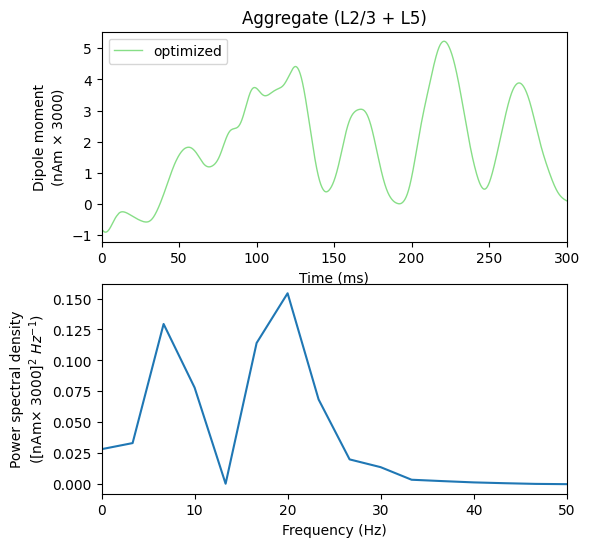

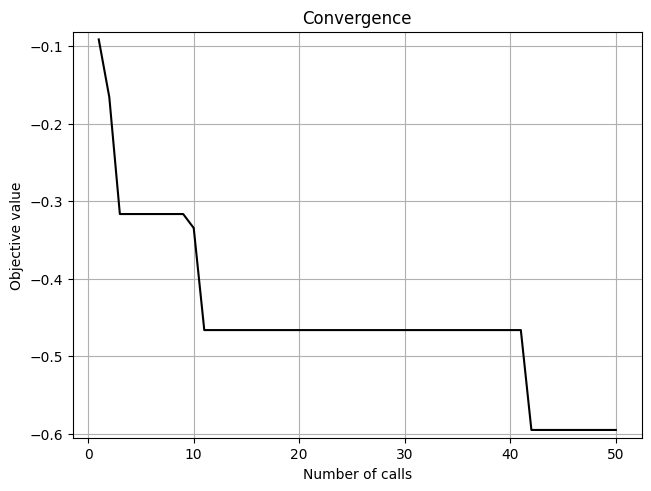

In [6]:
with MPIBackend(n_procs=n_procs, mpi_cmd='mpiexec'):
    opt_dpl = simulate_dipole(optim.net_, tstop=tstop, n_trials=1)[0]
opt_dpl.scale(scale_factor)
opt_dpl.smooth(smooth_window_len)

fig, axes = plt.subplots(2, 1, figsize=(6, 6))

# plot dipole
opt_dpl.plot(ax=axes[0], layer='agg', show=False, color='tab:green')
axes[0].legend(['optimized'])

# plot psd
plot_psd(opt_dpl, fmax=50, ax=axes[1], show=False)

# convergence
optim.plot_convergence()
plt.show()